# Imports

In [1]:
import os
from functools import partial
import json
import random

import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook

from gerrychain import (
    Election,
    Graph,
    MarkovChain,
    Partition,
    accept,
    constraints,
    updaters,
)

from gerrychain.metrics import efficiency_gap, mean_median, partisan_gini
from gerrychain.proposals import recom
from gerrychain.updaters import cut_edges
from gerrychain.tree import recursive_tree_part

# Downloading state data and building graph

In [2]:
# gdf = gpd.read_file("TX_vtds.shp")
# graph = Graph.from_geodataframe(gdf, ignore_errors = True)
# graph.add_data(gdf)

# Use this Code:

graph_path = "./texas.json"
graph = Graph.from_json(graph_path)
with open (graph_path, "r") as myfile:
    data=myfile.readlines()
graph_dict = json.loads(data[0])

# Chain stuff

In [3]:
pop_count = 0

for i in graph.nodes:
    pop_count += graph.nodes[i]["TOTPOP"]
    
print(pop_count)

25145561.0


In [4]:
%%time
num_dist = 36

my_updaters = {
    "population": updaters.Tally("TOTPOP", alias="population"),
    "cut_edges": cut_edges,
    #Note that 
    "ELECTION": Election("ELECTION", {"democratic":"PRES16D","republican":"PRES16R"})
}


# new_plan = recursive_tree_part(graph,
#                                range(num_dist),
#                                pop/num_dist,
#                                "TOTPOP",
#                                0.002,
#                                3)
initial_partition = Partition(graph,
                              "USCD",
                              my_updaters)

Wall time: 25 ms


In [5]:
%%time
proposal = partial(recom,
                   pop_col = "TOTPOP",
                   pop_target = pop/num_dist,
                   epsilon = 0.01,
                   node_repeats = 1)

compactness_bound = constraints.UpperBound(
    lambda p: len(p["cut_edges"]), 2 * len(initial_partition["cut_edges"])
)

Wall time: 132 ms


In [ ]:
%%time
def eg_bound(partition):
    bound = 1
    if partition.parent is not None:
        if efficiency_gap(partition.parent["ELECTION"]) > 0.08:
            bound = 0
    return random.random() < bound

In [ ]:
%%time
def eg_bound_decrease(partition):
    bound = 1
    if partition.parent is not None:
        if efficiency_gap(partition.parent["ELECTION"]) > 0.08:
            bound = 0
        else:
            if efficiency_gap(partition.parent["ELECTION"]) < efficiency_gap(partition["ELECTION"]):
                bound = .5
            else:
                bound = 1
    return random.random() < bound

In [7]:
%%time
def dem_seats_increase_int(partition):
    bound = 1
    if partition.parent is not None:
        if partition.parent["ELECTION"].wins("democratic") > partition["ELECTION"].wins("democratic"):
            bound = 0
    return random.random() < bound

Wall time: 0 ns


In [50]:
def dem_seats_increase_frac(partition):
    bound = 0
    if partition.parent is not None:
        i = partition.parent["ELECTION"].seats("democratic")
    if sorted(partition.parent["ELECTION"].percents("republican"))[i-1] >= sorted(partition["ELECTION"].percents("republican"))[i-1]:
        bound = 1
    return random.random() < bound       

In [ ]:
##gabe code

%%time
def two_rep(partition):
    bound = 1
    if partition.parent is not None:
        if sorted(partition.parent[election].percents("republican"))[-1] < 0.5:
            if sorted(partition.parent[election].percents(“republican”))[-1] >= sorted(partition[election].percents(“republican”))[-1]:
                bound = 0
        else:
            if sorted(partition[election].percents(“republican”))[-2] < 0.5:
                if sorted(partition.parent[election].percents(“republican”))[-2] >= sorted(partition[election].percents(“republican”))[-2]:
                    bound = 0
    return random.random() < bound

In [46]:
%%time
chain = MarkovChain(
    proposal=proposal,
    constraints=[
        constraints.within_percent_of_ideal_population(initial_partition, 0.05),
        compactness_bound,
    ],
    #accept = dem_seats_increase_frac,
    accept = accept.always_accept,
    initial_state = initial_partition,
    total_steps=10000,
)

Wall time: 1 ms


# Pulling data from chain run

In [47]:
%%time

seatdata = [] #Number of Democratic seats in each step
egdata = []
R_votes = []
D_votes = []

rho = []
T_D = []
T_R = []
t = 0

for step in chain:
    seatdata.append(step["ELECTION"].wins("democratic"))
    egdata.append(efficiency_gap(step["ELECTION"]))
    D_votes.append(step["ELECTION"].votes("democratic"))
    R_votes.append(step["ELECTION"].votes("republican"))
    T_Dem = 0
    T_Rep = 0
    for part in step.parts.keys():
        if step["ELECTION"].won("democratic", part) == True:
            T_Dem += step["ELECTION"].count("democratic", part) + step["ELECTION"].count("republican", part)
        else:
            T_Rep += step["ELECTION"].count("democratic", part) + step["ELECTION"].count("republican", part)
    r = (T_Rep/step["ELECTION"].wins("republican"))/(T_Dem/step["ELECTION"].wins("democratic"))
    rho.append(r)
    T_D.append(T_Dem)
    T_R.append(T_Rep)
    
    t+=1
    if t%100 ==0:
        print(t)
        


100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
Wall time: 2h 42min 42s


In [82]:
#Need to save:

# seatdata = []
with open('Ensemble_D_seats.csv', 'w', newline='') as csvfile:
    #writer = csv.writer(csvfile)
    writer = csv.writer(csvfile, delimiter=',')
    writer.writerows([[i] for i in seatdata])
    
    
# egdata = []
with open('Ensemble_EG.csv', 'w', newline='') as csvfile:
    #writer = csv.writer(csvfile)
    writer = csv.writer(csvfile, delimiter=',')
    writer.writerows([[i] for i in egdata])

# R_votes = []
with open('Ensemble_R_votes.csv', 'w', newline='') as csvfile:
    #writer = csv.writer(csvfile)
    writer = csv.writer(csvfile, delimiter=',')
    writer.writerows([[i] for i in R_votes])

# D_votes = []
with open('Ensemble_D_votes.csv', 'w', newline='') as csvfile:
    #writer = csv.writer(csvfile)
    writer = csv.writer(csvfile, delimiter=',')
    writer.writerows([[i] for i in D_votes])

# rho = []
with open('Ensemble_rho.csv', 'w', newline='') as csvfile:
    #writer = csv.writer(csvfile)
    writer = csv.writer(csvfile, delimiter=',')
    writer.writerows([[i] for i in rho])

# T_D = []
with open('Ensemble_turnout_D.csv', 'w', newline='') as csvfile:
    #writer = csv.writer(csvfile)
    writer = csv.writer(csvfile, delimiter=',')
    writer.writerows([[i] for i in T_D])

# T_R = []
with open('Ensemble_turnout_R.csv', 'w', newline='') as csvfile:
    #writer = csv.writer(csvfile)
    writer = csv.writer(csvfile, delimiter=',')
    writer.writerows([[i] for i in T_R])


In [83]:
import csv
test = []    
with open('Ensemble_EG.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        test.append(', '.join(row))
test2 = []
for i in range(10):
     test2.append(float(test[i]))   

In [85]:
test2

[-0.09128250996214164,
 -0.09128250996214164,
 -0.09128250996214164,
 -0.09128250996214164,
 -0.09128250996214164,
 -0.08672628573470838,
 -0.08672628573470838,
 -0.07592741529522487,
 -0.07464721089233085,
 -0.07464721089233085]

In [86]:
PRES16R_TX = 0
PRES16D_TX = 0
TOTTO16_TX = 0

for i in range(len(graph.nodes())):
    PRES16R_TX += graph.nodes[i]["PRES16R"]
    PRES16D_TX += graph.nodes[i]["PRES16D"]
    TOTTO16_TX += graph.nodes[i]["TOTTO16"]

V = PRES16D_TX/(PRES16R_TX + PRES16D_TX)

In [87]:
eg_ideal = []
difference = []
for i in range(10000):
    eg_ideal.append((seatdata[i])/36 - 2*V + 0.5)
    difference.append(egdata[i] - eg_ideal[i])
#Why is eg_ideal usually bigger? Because rho > 1 because dem winning districts have low turnout

In [90]:
num_values = max(seatdata) - min(seatdata) + 1
print(num_values)

10


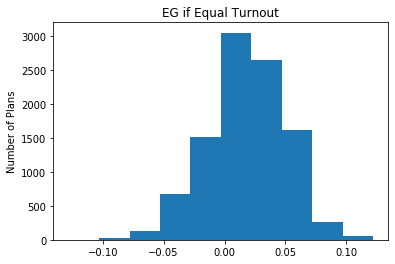

In [91]:
plt.hist(eg_ideal, bins=num_values)
plt.title('EG if Equal Turnout')
plt.ylabel('Number of Plans')
plt.savefig("EG_ideal.png", dpi = 1200)

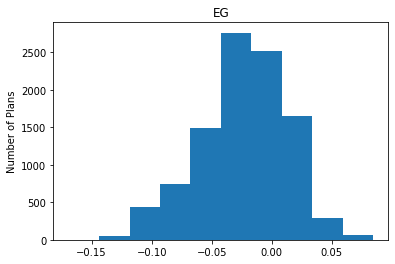

In [92]:
plt.hist(egdata)
plt.title('EG')
plt.ylabel('Number of Plans')
plt.savefig("EG.png", dpi = 1200)

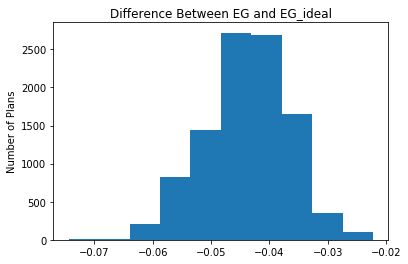

In [93]:
plt.hist(difference)
#plt.axvline(.551, color='red', linestyle='dashed', linewidth=1, label='Descending alpha Plan')
#plt.legend(loc='upper right')
plt.title('Difference Between EG and EG_ideal')
plt.ylabel('Number of Plans')
plt.savefig("EG_difference_EG_ideal.png", dpi = 1200)

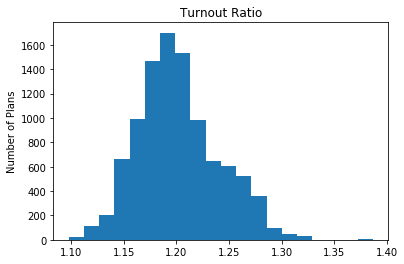

In [95]:
plt.hist(rho, bins = 20)
plt.title('Turnout Ratio')
plt.ylabel('Number of Plans')
plt.savefig("rho.png", dpi = 1200)

# Visualization

Wall time: 10.2 s


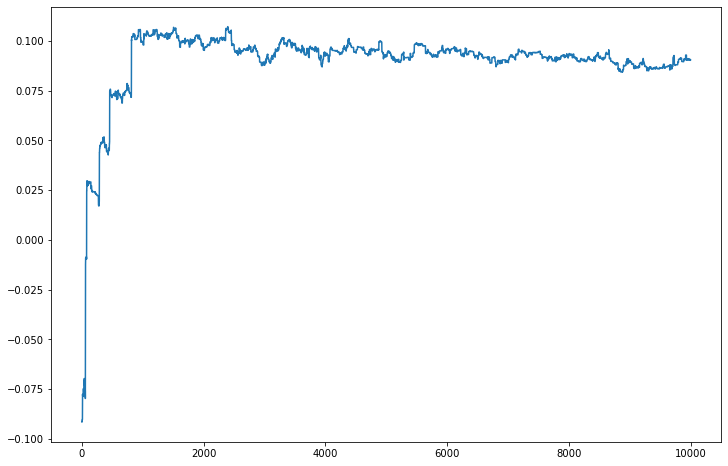

In [60]:
%%time
fig, seats = plt.subplots(figsize=(12,8))
seats.plot(egdata)
# plt.savefig("eg_gerrywalk_frac_tx10000.png", dpi = 1200)

# most_rep_dist = []
# one_rep_plans = []
# for plan in data:
#     most_rep_dist.append(sorted(plan[3])[-1])
#     if sorted(plan[3])[-1] >= 0.5:
#         one_rep_plans.append(plan)
# rep_dist.plot(most_rep_dist, color=“red”)
# rep_dist.set_title(“Republican vote share in most Republican district”)
# rep_dist.set_ylabel(“Rep vote share”)
# rep_dist.set_xlabel(“Step in chain”)

In [ ]:
data2 = []
for value in data:
    data2.append(value[0])
data2

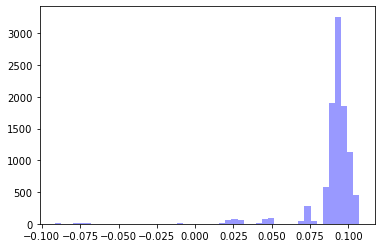

In [61]:
import seaborn as sns
fig = sns.distplot(egdata, kde=False, color="b")
# plt.savefig("eg_gerrydist_frac_tx10000.png", dpi = 1200)

In [ ]:
plt.savefig()

In [ ]:
print(data[5674])

In [ ]:
%%time
# fig, votes = plt.subplots(figsize=(16,4))
fig, seats = plt.subplots(figsize=(16,4))
fig, ax = plt.subplots(2,2, figsize=(16,8), sharex="col", sharey="row")

plt.subplots_adjust(wspace=0.3, hspace=0.3)

# Variables
inliers = [22,27]
bins_num = 20
out_bins_num = 10
title = "TX-PR16: 10000 ReCom plans"

# Colors
seats_colors = ["red", "blue", "lightgray"]
party_colors = ["red", "blue"]
neutral = "lightgreen"

# Creating Datasets
mm = []
pg = []
vs = []
mm_routliers = []
mm_doutliers = []
pg_routliers = []
pg_doutliers = []
seats_routliers = []
seats_doutliers = []
seats_inliers = []
vs_routliers = []
vs_doutliers = []


for plan in data:
    mm.append(plan[1])
    pg.append(plan[2])
    vs.append(plan[3])
    if plan[0] < inliers[0]:
        seats_doutliers.append(plan[0])
        mm_doutliers.append(plan[1])
        pg_doutliers.append(plan[2])
        vs_doutliers.append(plan[3])
    if plan[0] > inliers[1]:
        seats_routliers.append(plan[0])
        mm_routliers.append(plan[1])
        pg_routliers.append(plan[2])
        vs_routliers.append(plan[3])
    if plan[0] >= inliers[0] and plan[0] <= inliers[1]:
        seats_inliers.append(plan[0])

mms = [mm_routliers, mm_doutliers]
pgs = [pg_routliers, pg_doutliers]
seats_colored = [seats_routliers, seats_doutliers, seats_inliers]

# More variables
num_outliers = str(len(mm_doutliers) + len(mm_routliers))
pct_outliers = str(round((len(mm_doutliers) + len(mm_routliers)) / 10000 * 100, 1))
title_w = "TX-S12: " + num_outliers + " outlier plans " + "(" + pct_outliers + "%)"

# Plotting the votes shares boxplots
# votes.boxplot(vs, positions=range(len(data.columns)))

# votes.set_title("Votes Shares Boxplots")
# votes.set_ylabel("Republican Votes %")
# votes.set_xlabel("District #")


# Plotting the seats histogram
seats.hist(seats_colored, bins=out_bins_num, stacked=True, color=seats_colors)

seats.set_title("TX-S12 Republican seats won — outliers colored according to party helped")
seats.set_ylabel("Frequency")
seats.set_xlabel("# Seats Won")
seats.set_xlim(0, num_dist)
seats.axvline(x = num_dist/2, color=neutral, linestyle="dashed", linewidth=2, label="50% seats")
seats.axvline(x = num_dist * initial_partition["Election"].percent("republican"), color="red", linestyle="dashed", linewidth=2, label="proportionality")
seats.legend()
# seats.set_xticks(1)

# Plotting the whole dataset
ax[0,0].hist(mm, bins=2*bins_num, color=neutral)
ax[0,1].hist(pg, bins=2*bins_num, color=neutral)

ax[0,0].set_title(title)
ax[0,0].set_ylabel("Frequency")
ax[0,0].set_xlabel("Mean-Median Score")

ax[0,1].set_title(title)
ax[0,1].set_ylabel("Frequency")
ax[0,1].set_xlabel("Partisan Gini Score")

# Plotting the winnowed data
ax[1,0].hist(mms, bins=bins_num, color=party_colors)
ax[1,1].hist(pgs, bins=bins_num, color=party_colors)
# ax[1,1].set_ylim((0,40))

ax[1,0].set_title(title_w)
ax[1,0].set_ylabel("Frequency")
ax[1,0].set_xlabel("Mean-Median Score")

ax[1,1].set_title(title_w)
ax[1,1].set_ylabel("Frequency")
ax[1,1].set_xlabel("Partisan Gini Score")